In [1]:
!pip install split-folders
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import splitfolders

splitfolders.ratio("SolarPanel_Dataset", output="SolarPanel_Dataset", seed=42, ratio=(.7, .2, .1))

PermissionError: [Errno 13] Permission denied: 'SolarPanel_Dataset\\train\\Bird-drop\\desktop.ini'

In [2]:
from PIL import Image
import os

def validate_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except Exception as e:
                print(f"Corrupted: {img_path}")


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # optional
)

train_generator = train_datagen.flow_from_directory(
    'SolarPanel_Dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 693 images belonging to 6 classes.


In [4]:
import os
from collections import Counter

root_dir = 'SolarPanel_Dataset/train'
class_counts = {cls: len(os.listdir(os.path.join(root_dir, cls))) for cls in os.listdir(root_dir)}
print(class_counts)


{'Bird-drop': 176, 'Clean': 180, 'Dusty': 133, 'Electrical-damage': 72, 'Physical-Damage': 49, 'Snow-Covered': 86}


In [6]:
def dataset_summary(root_path):
    for folder in os.listdir(root_path):
        path = os.path.join(root_path, folder)
        count = len([file for file in os.listdir(path) if file.endswith(('.jpg', '.png', '.jpeg'))])
        print(f"{folder}: {count} images")

dataset_summary("SolarPanel_Dataset/train")


Bird-drop: 157 images
Clean: 173 images
Dusty: 132 images
Electrical-damage: 65 images
Physical-Damage: 45 images
Snow-Covered: 75 images


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data = train_gen.flow_from_directory(
    'SolarPanel_Dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 693 images belonging to 6 classes.


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = ['Bird-Drop', 'Clean', 'Dusty', 'Electrical-Damage', 'Physical-Damage', 'Snow-Covered']
y = (
    ['Bird-Drop'] * 171 +
    ['Clean'] * 185 +
    ['Dusty'] * 190 +
    ['Electrical-Damage'] * 90 +
    ['Physical-Damage'] * 66 +
    ['Snow-Covered'] * 105
)
weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=y)
class_weights = dict(zip(classes, weights))
print("📊 Class Weights (realistic):")
for k, v in class_weights.items():
    print(f"{k}: {v:.2f}")


📊 Class Weights (realistic):
Bird-Drop: 0.79
Clean: 0.73
Dusty: 0.71
Electrical-Damage: 1.49
Physical-Damage: 2.04
Snow-Covered: 1.28


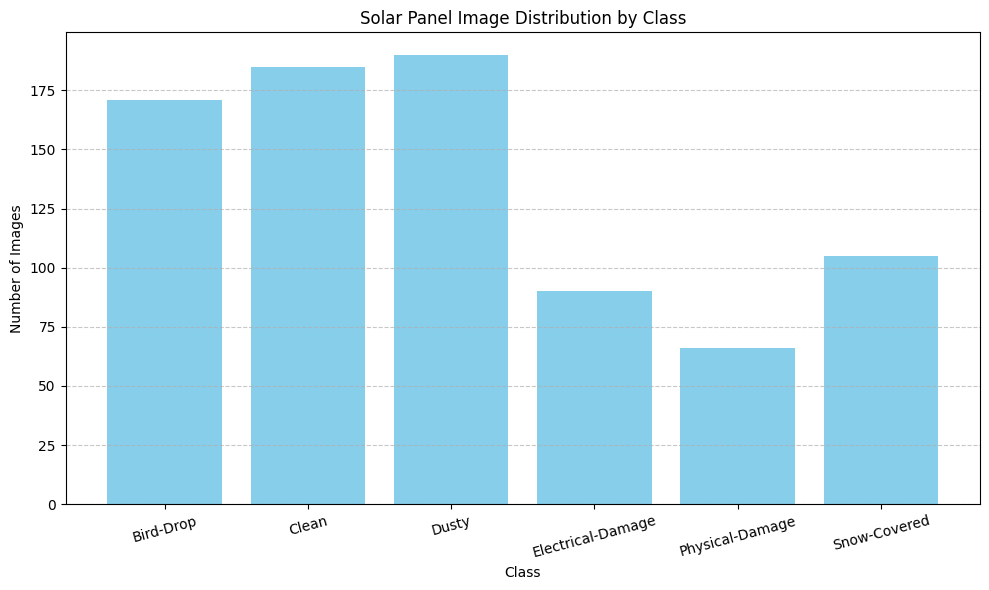

In [10]:
import matplotlib.pyplot as plt

class_counts = {
    'Bird-Drop': 171,
    'Clean': 185,
    'Dusty': 190,
    'Electrical-Damage': 90,
    'Physical-Damage': 66,
    'Snow-Covered': 105
}

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Solar Panel Image Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


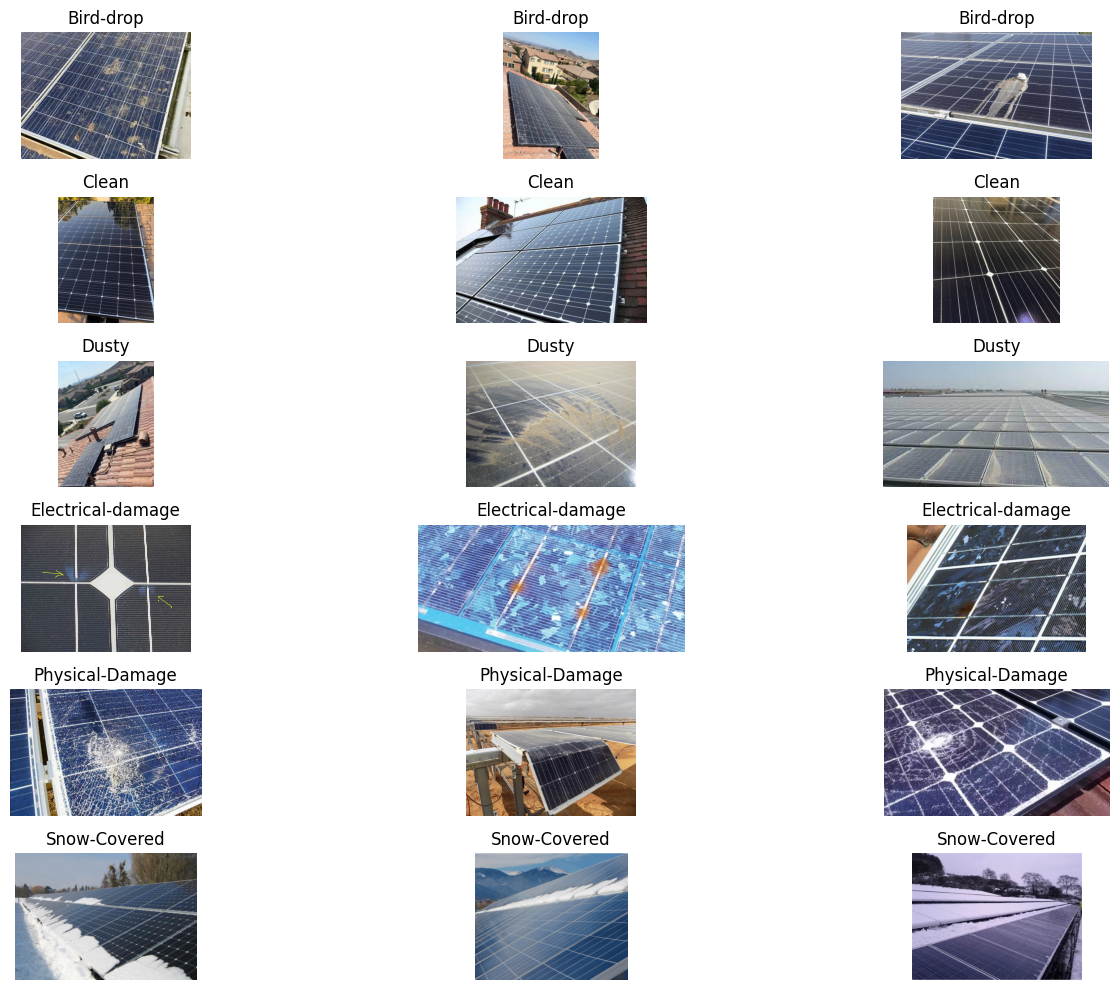

In [11]:
import os
import random
from PIL import Image

dataset_path = 'SolarPanel_Dataset/train'
classes = os.listdir(dataset_path)

plt.figure(figsize=(15, 10))

i = 1
for label in classes:
    folder = os.path.join(dataset_path, label)
    images = random.sample(os.listdir(folder), 3)  
    for img_file in images:
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        plt.subplot(len(classes), 3, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


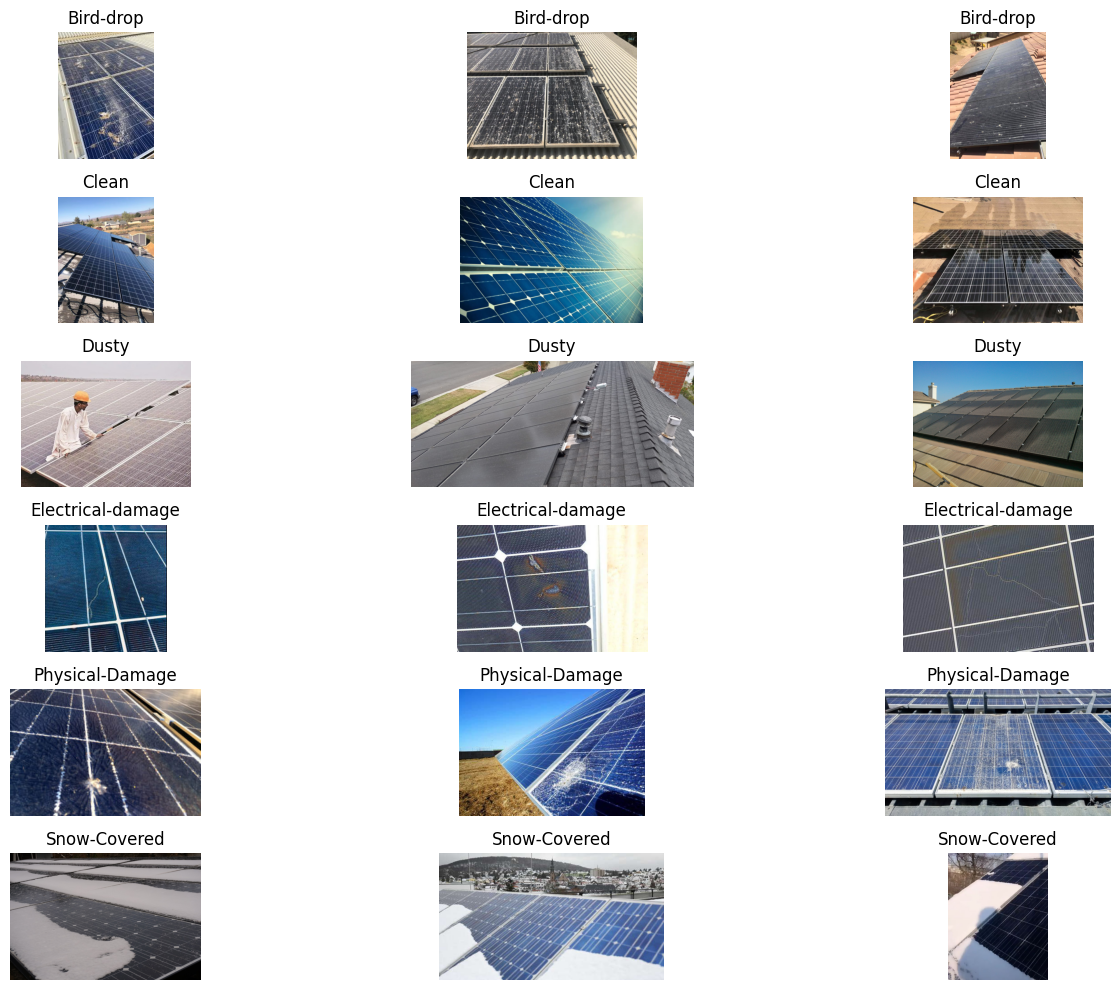

In [12]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = 'SolarPanel_Dataset/train'
valid_exts = ['.jpg', '.jpeg', '.png']
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

plt.figure(figsize=(15, 10))
i = 1

for label in classes:
    folder = os.path.join(dataset_path, label)
    
    images = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in valid_exts]
    sample_images = random.sample(images, min(3, len(images)))  
    for img_file in sample_images:
        img_path = os.path.join(folder, img_file)
        try:
            img = Image.open(img_path)
            plt.subplot(len(classes), 3, i)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            i += 1
        except Exception as e:
            print(f"Skipped: {img_path} due to error: {e}")

plt.tight_layout()
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

IMG_SIZE = 224
NUM_CLASSES = 6

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'SolarPanel_Dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'SolarPanel_Dataset/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

print("Class indices:", train_gen.class_indices)  


Found 693 images belonging to 6 classes.
Found 232 images belonging to 6 classes.
Class indices: {'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}


In [15]:
print(train_gen.class_indices)


{'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}


In [16]:
class_weights = {
    0: 0.79,  # Bird-Drop
    1: 0.73,  # Clean
    2: 0.71,  # Dusty
    3: 1.49,  # Electrical-Damage
    4: 2.04,  # Physical-Damage
    5: 1.28   # Snow-Covered
}

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2240 - loss: 2.1490 - val_accuracy: 0.5000 - val_loss: 1.3323
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4592 - loss: 1.3433 - val_accuracy: 0.6034 - val_loss: 1.1219
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5173 - loss: 1.1615 - val_accuracy: 0.6509 - val_loss: 0.9327
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6446 - loss: 0.9844 - val_accuracy: 0.6336 - val_loss: 0.9051
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6507 - loss: 0.9023 - val_accuracy: 0.7112 - val_loss: 0.8123
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7160 - loss: 0.7808 - val_accuracy: 0.7112 - val_loss: 0.8048
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6899 - loss: 0.7613 - val_accuracy: 0.6810 - val_loss: 0.8496
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7184 - loss: 0.7371 - val_accuracy: 0.7371 - val_loss:

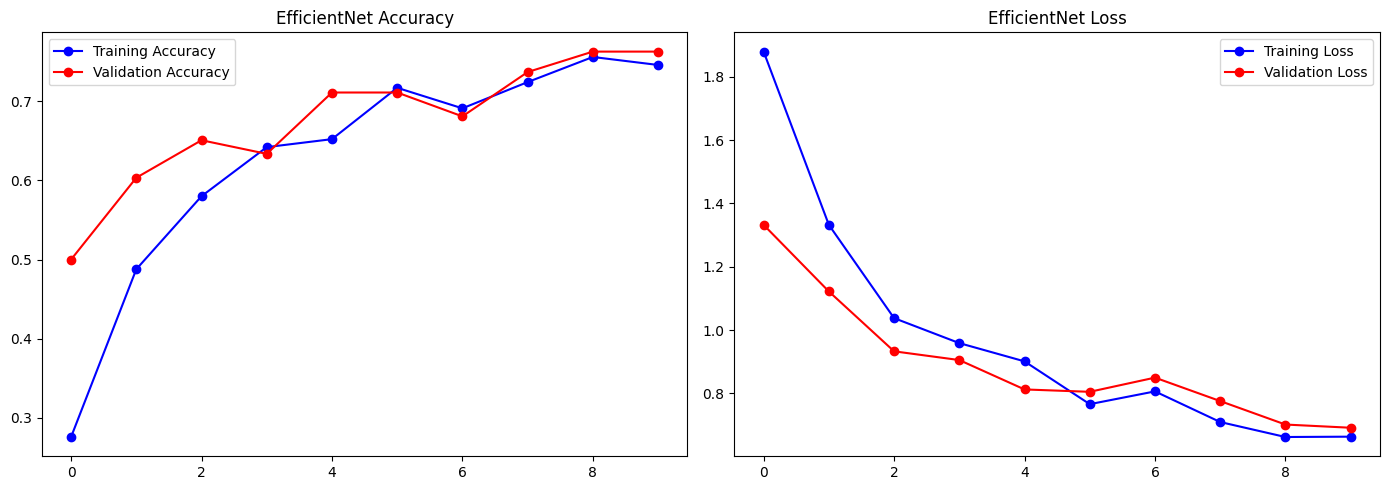

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('EfficientNet Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('EfficientNet Loss')
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


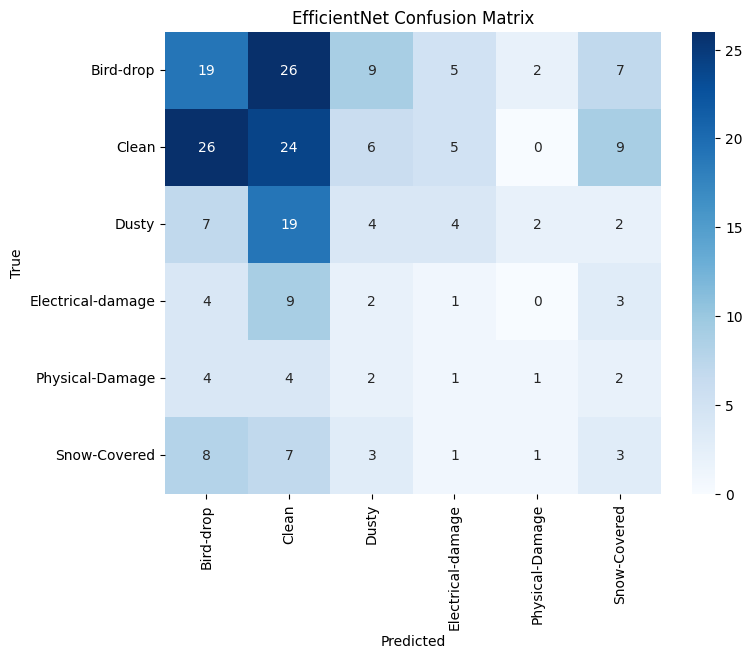

                   precision    recall  f1-score   support

        Bird-drop       0.28      0.28      0.28        68
            Clean       0.27      0.34      0.30        70
            Dusty       0.15      0.11      0.12        38
Electrical-damage       0.06      0.05      0.06        19
  Physical-Damage       0.17      0.07      0.10        14
     Snow-Covered       0.12      0.13      0.12        23

         accuracy                           0.22       232
        macro avg       0.17      0.16      0.16       232
     weighted avg       0.21      0.22      0.22       232



In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNet Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))


In [18]:
model.save("solar_defect_model.keras")
